In [1]:
%matplotlib inline

import math
import warnings
import numpy as np

# specify to ignore warning messages
warnings.filterwarnings("ignore") 

import keras
from lstm_utils import get_raw_data
from lstm_utils import get_reg_model
from lstm_utils import plot_reg_results
from lstm_utils import get_reg_train_test
from lstm_utils import predict_reg_multiple

from sklearn.metrics import mean_squared_error

Using Theano backend.


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.set_context('talk')

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

## Set Parameters

In [3]:
WINDOW = 6
PRED_LENGTH = int(WINDOW/2)
STOCK_INDEX = '^GSPC'

## Getting Data

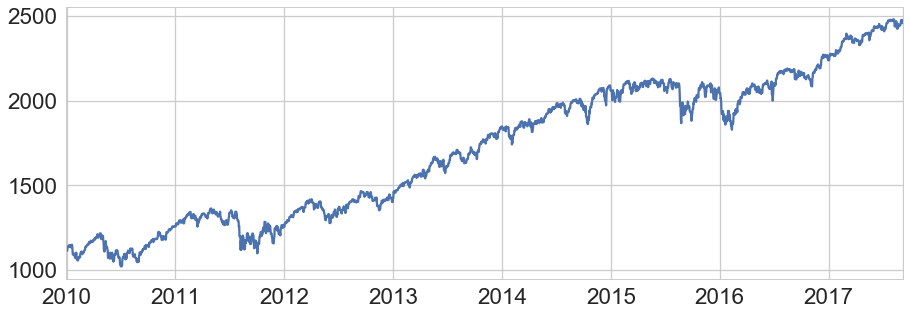

In [4]:
sp_df = get_raw_data(STOCK_INDEX)
sp_close_series = sp_df.Close 

sp_close_series.plot()

## Preprocessing Data

In [5]:
x_train,y_train,x_test,y_test,scaler = get_reg_train_test(sp_close_series,
                                                      sequence_length=WINDOW+1,
                                                      roll_mean_window=None,
                                                      normalize=True,
                                                      scale=False)
    
print("Data Split Complete")

print("x_train shape={}".format(x_train.shape))
print("y_train shape={}".format(y_train.shape))
print("x_test shape={}".format(x_test.shape))
print("y_test shape={}".format(y_test.shape))

Data Split Complete
x_train shape=(2522, 6, 1)
y_train shape=(2522,)
x_test shape=(280, 6, 1)
y_test shape=(280,)


## Prepare LSTM Model

In [6]:
lstm_model=None
try:
    lstm_model = get_reg_model(layer_units=[50,100],
                           window_size=WINDOW)   
except:
    print("Model Build Failed. Trying Again")
    lstm_model = get_reg_model(layer_units=[50,100],
                           window_size=WINDOW)

Model Build Failed. Trying Again
> Compilation Time :  0.008021354675292969
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 6, 50)             10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 70,901
Trainable params: 70,901
Non-trainable params

## Fit the Model

In [7]:
# use eatrly stopping to avoid overfitting     
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=2,
                                           verbose=0)]
lstm_model.fit(x_train, y_train, 
               epochs=20, batch_size=16,
               verbose=1,validation_split=0.05,
               callbacks=callbacks)
print("Model Fit Complete")

Train on 2395 samples, validate on 127 samples
Epoch 1/20
2395/2395 [==============================] - 1s - loss: 2.4231e-04 - val_loss: 4.0135e-05
Epoch 2/20
2395/2395 [==============================] - 1s - loss: 1.1636e-04 - val_loss: 3.9069e-05
Epoch 3/20
2395/2395 [==============================] - 2s - loss: 9.7342e-05 - val_loss: 2.8527e-05
Epoch 4/20
2395/2395 [==============================] - 2s - loss: 9.4975e-05 - val_loss: 5.5308e-05
Epoch 5/20
2395/2395 [==============================] - 2s - loss: 9.1180e-05 - val_loss: 2.9796e-05
Epoch 6/20
2395/2395 [==============================] - 2s - loss: 8.8870e-05 - val_loss: 2.8242e-05
Epoch 7/20
2395/2395 [==============================] - 2s - loss: 8.8455e-05 - val_loss: 2.8539e-05
Epoch 8/20
2395/2395 [==============================] - 2s - loss: 8.9470e-05 - val_loss: 2.6032e-05
Epoch 9/20
2395/2395 [==============================] - 2s - loss: 8.6262e-05 - val_loss: 2.5722e-05
Epoch 10/20
2395/2395 [=====================

## Train Prediction Performance

In [9]:
train_pred_seqs = predict_reg_multiple(lstm_model,
                                             x_train,
                                             window_size=WINDOW,
                                             prediction_len=PRED_LENGTH)

train_offset = y_train.shape[0] - np.array(train_pred_seqs).flatten().shape[0]

train_rmse = math.sqrt(mean_squared_error(y_train[train_offset:], 
                                          np.array(train_pred_seqs).\
                                          flatten()))
print('Train Score: %.2f RMSE' % (train_rmse))

Train Score: 0.02 RMSE


## Test Prediction Performance

In [10]:
test_pred_seqs = predict_reg_multiple(lstm_model,
                                      x_test,
                                      window_size=WINDOW,
                                      prediction_len=PRED_LENGTH)
test_offset = y_test.shape[0] - np.array(test_pred_seqs).flatten().shape[0]

test_rmse = math.sqrt(mean_squared_error(y_test[test_offset:], 
                                          np.array(test_pred_seqs).\
                                          flatten()))
print('Test Score: %.2f RMSE' % (test_rmse))

Test Score: 0.01 RMSE


## Plot Test Predictions

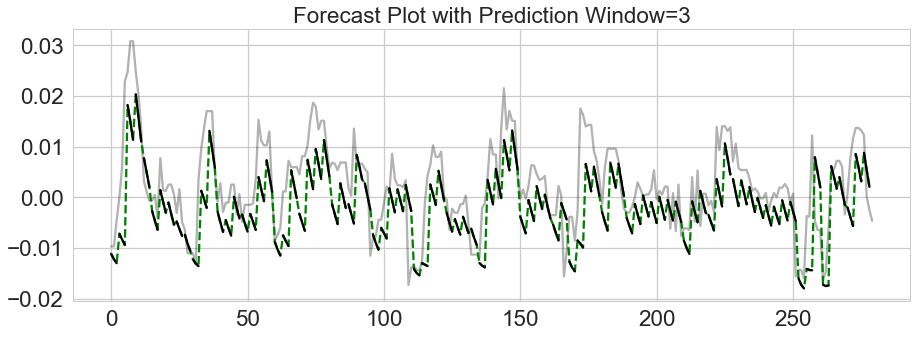

In [11]:
plot_reg_results(test_pred_seqs,y_test,prediction_len=PRED_LENGTH)